# **A/B Test Simulation – Single Run**
<hr style="border:1px solid #444;">

#### **Objective**
This notebook simulates a single A/B test across multiple e-commerce product categories to measure lift in conversion rate.

### **Notebook Structure**
The notebook is organized into the following sections (top-to-bottom):

1. Simulation Test Data
2. Aggregate Results and Calculate Metrics
3. Plot 1 - Conversion Rate by Category and Group
4. Plot 2 - Lift Percentage
5. Summary Table


---

### Section 1: Simulate Test Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set seed for reproducibility
np.random.seed(42)

n = 100_000
categories = ['Electronics', 'Clothing', 'Home Goods', 'Beauty', 'Toys']
group = np.random.choice(['A', 'B'], size=n)
category = np.random.choice(categories, size=n)
visits = np.random.randint(50, 300, size=n)

base_conversion = {
    'Electronics': 0.05,
    'Clothing': 0.08,
    'Home Goods': 0.04,
    'Beauty': 0.07,
    'Toys': 0.06
}
lift = {
    'Electronics': 0.02,
    'Clothing': 0.01,
    'Home Goods': 0.03,
    'Beauty': 0.00,
    'Toys': -0.01
}

# Simulate binary outcomes (1 = success, 0 = failure)
conversions = []
for g, c, v in zip(group, category, visits):
    rate = base_conversion[c] + (lift[c] if g == 'B' else 0)
    conv = np.random.binomial(v, np.clip(rate, 0, 1))
    conversions.append(conv)
    

<hr style="border:1px solid #444;">


### Section 2: Aggregate Results and Calculate Metrics

In [13]:
# Create summary DataFrame for display
df = pd.DataFrame({'Group': group, 'Category': category, 'Visits': visits, 'Conversions': conversions})
df['Rate'] = df['Conversions'] / df['Visits']

agg_df = df.groupby(['Category', 'Group'])[['Visits', 'Conversions']].sum().reset_index()
agg_df['Rate'] = agg_df['Conversions'] / agg_df['Visits']
agg_df['StdErr'] = np.sqrt(agg_df['Rate'] * (1 - agg_df['Rate']) / agg_df['Visits'])

rate_pivot = agg_df.pivot(index='Category', columns='Group', values='Rate').reset_index()
se_pivot = agg_df.pivot(index='Category', columns='Group', values='StdErr').reset_index()

summary_df = rate_pivot.rename(columns={'A': 'Rate_A', 'B': 'Rate_B'})
summary_df['Lift_%'] = ((summary_df['Rate_B'] - summary_df['Rate_A']) / summary_df['Rate_A']) * 100
summary_df['StdErr_A'] = se_pivot['A']
summary_df['StdErr_B'] = se_pivot['B']
summary_df['Lift_StdErr'] = np.sqrt((summary_df['StdErr_A'] / summary_df['Rate_A']) ** 2 +
                                    (summary_df['StdErr_B'] / summary_df['Rate_B']) ** 2) * np.abs(summary_df['Lift_%'])

# Compute z-score
summary_df['Z_score'] = (summary_df['Rate_B'] - summary_df['Rate_A']) / np.sqrt(
    summary_df['StdErr_A']**2 + summary_df['StdErr_B']**2)

# Compute one-tailed p-value from z-score
summary_df['P_value'] = 2 * (1 - norm.cdf(np.abs(summary_df['Z_score'])))


<hr style="border:1px solid #444;">


### Section 3: Plot 1 - Conversion Rate by Category and Group

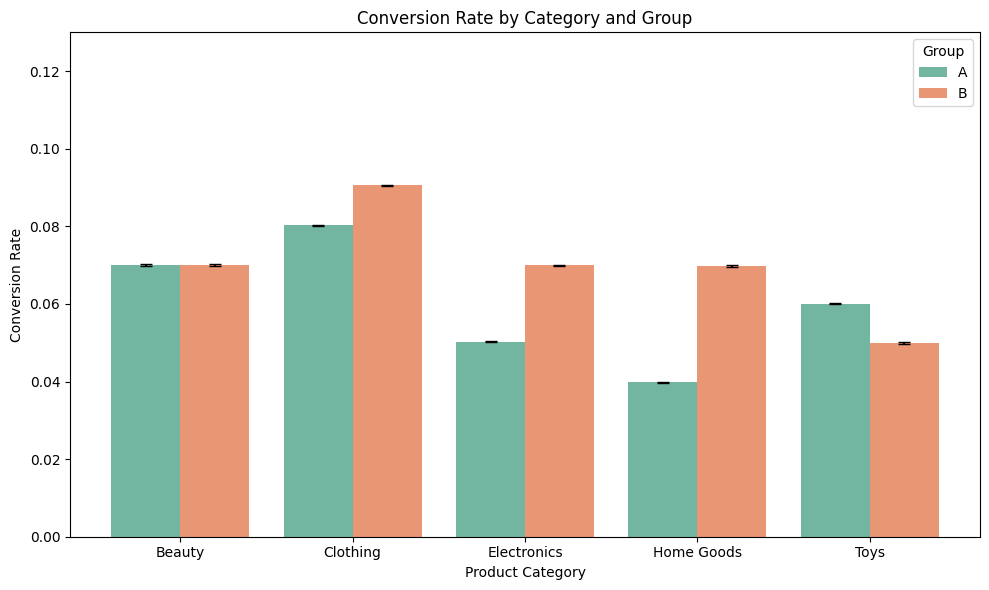

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df, x='Category', y='Rate', hue='Group', palette='Set2', errorbar=None)
for i in range(len(agg_df)):
    row = agg_df.iloc[i]
    x_offset = -0.2 if row['Group'] == 'A' else 0.2
    x = i // 2 + x_offset
    plt.errorbar(x, row['Rate'], yerr=row['StdErr'], fmt='none', ecolor='black', capsize=4)

plt.title("Conversion Rate by Category and Group")
plt.ylabel("Conversion Rate")
plt.xlabel("Product Category")
plt.ylim(0, 0.13)
plt.legend(title='Group')
plt.tight_layout()
plt.savefig('../../assets/ab_testing/ab_single_run_conversion_rates.png', bbox_inches='tight', dpi=300)
plt.show()


<hr style="border:1px solid #444;">


### Section 4: Plot 2 - Lift Percentage

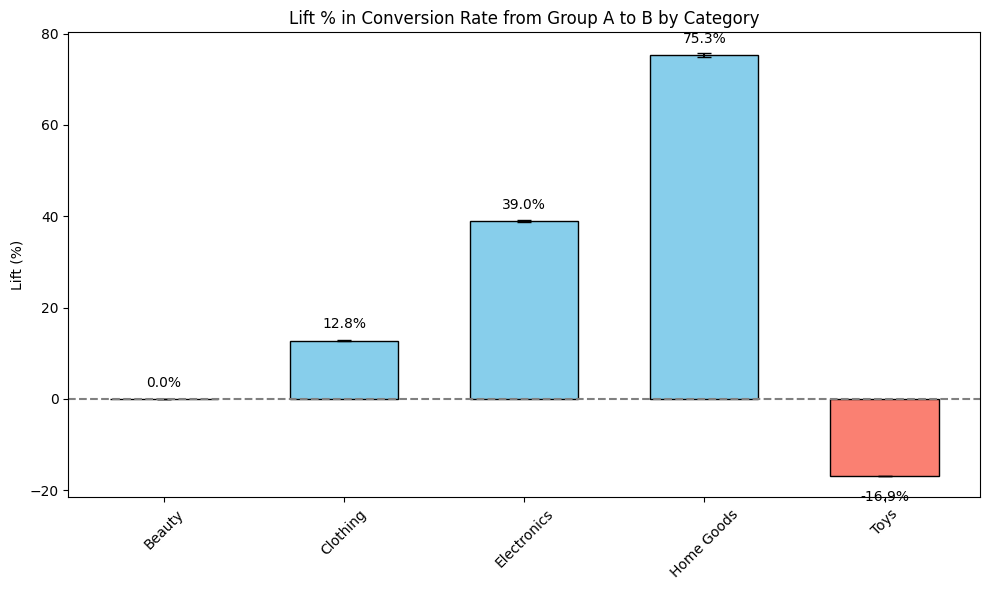

In [15]:
plt.figure(figsize=(10, 6))
colors = ['skyblue' if val >= 0 else 'salmon' for val in summary_df['Lift_%']]
x = np.arange(len(summary_df))

bars = plt.bar(x, summary_df['Lift_%'], color=colors, edgecolor='black', width=0.6)
plt.errorbar(x, summary_df['Lift_%'], yerr=summary_df['Lift_StdErr'], fmt='none', ecolor='black', capsize=5)

for i, val in enumerate(summary_df['Lift_%']):
    plt.text(i, val + (2 if val >= 0 else -3), f"{val:.1f}%", ha='center', va='bottom' if val >= 0 else 'top')

plt.axhline(0, color='gray', linestyle='--')
plt.xticks(x, summary_df['Category'], rotation=45)
plt.title("Lift % in Conversion Rate from Group A to B by Category")
plt.ylabel("Lift (%)")
plt.tight_layout()
plt.savefig('../../assets/ab_testing/ab_single_run_lift_by_category.png', bbox_inches='tight', dpi=300)
plt.show()


<hr style="border:1px solid #444;">


### Section 5: Summary Table

In [16]:
pd.set_option("display.precision", 4)
summary_df[['Category', 'Rate_A', 'StdErr_A', 'Rate_B', 'StdErr_B', 'Lift_%', 'Lift_StdErr', 'Z_score', 'P_value']]


Group,Category,Rate_A,StdErr_A,Rate_B,StdErr_B,Lift_%,Lift_StdErr,Z_score,P_value
0,Beauty,0.0700,0.0002,0.0700,0.0002,0.0020,7.9539e-06,0.0052,0.9959
1,Clothing,0.0803,0.0002,0.0905,0.0002,12.8026,4.4722e-02,34.5043,0.0000
2,Electronics,0.0503,0.0002,0.0699,0.0002,39.0054,1.6771e-01,77.2605,0.0000
3,Home Goods,0.0398,0.0001,0.0698,0.0002,75.2933,3.4994e-01,122.8904,0.0000
4,Toys,0.0601,0.0002,0.0500,0.0002,-16.8505,7.4712e-02,-41.6756,0.0000


The A/B test was performed across five product categories to evaluate whether the treatment (Group B) significantly affected conversion rates compared to the control (Group A). A z-test for proportions was applied to each category to measure lift, statistical confidence, and significance.

**Key Results:**

- **Clothing, Electronics, and Home Goods** showed strong positive lift and extremely high z-scores with **p-values < 0.001**, indicating a **statistically significant improvement** in conversion rates for Group B
- **Toys** demonstrated a **statistically significant negative lift** (-16.85%), suggesting the treatment may have adversely impacted conversions in this segment
- **Beauty** had an insignificant lift (~0.2%) with a **p-value of 0.9959**, suggesting **no meaningful difference** between control and variant

**Interpretation:**

- The **statistically significant uplift** in key categories supports a positive business impact of the treatment
- The **Toys category may require re-evaluation**, as the treatment had a detrimental effect
- The **Beauty segment's result may be due to random noise**, and does not warrant campaign changes

**Recommendation:**

- **Roll out** the treatment across Clothing, Electronics, and Home Goods
- **Investigate** the negative response in Toys for possible UX or targeting issues
- **No action** needed for Beauty until further data confirms a trend

<hr style="border:1px solid #444;">
